# Setup

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ESA-Datalabs/XAMI-model/blob/main/dataset_and_model.ipynb)

In [2]:
import sys
import os

if 'google.colab' in sys.modules:
    !pip install -q condacolab
    import condacolab
    condacolab.install()

In [ ]:
# skip this step if the package already exists
!git clone https://github.com/ESA-Datalabs/XAMI-model.git
os.chdir("XAMI-model")
!conda env update -n base -f environment.yaml
!pip install -e .

## Download dataset

In [2]:
!git clone https://github.com/ESA-Datalabs/XAMI-dataset.git
!pip install -e XAMI-dataset/

Cloning into 'XAMI-dataset'...
remote: Enumerating objects: 291, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 291 (delta 18), reused 6 (delta 2), pack-reused 251 (from 1)
Receiving objects: 100% (291/291), 3.58 MiB | 4.34 MiB/s, done.
Resolving deltas: 100% (139/139), done.
Obtaining file:///Users/iulia/Desktop/tempp/XAMI-model/XAMI-dataset
  Preparing metadata (setup.py) ... done
  Attempting uninstall: xami_dataset
    Found existing installation: xami_dataset 0.1
    Can't uninstall 'xami_dataset'. No files were found to uninstall.
  DEPRECATION: Legacy editable install of xami_dataset==0.1 from file:///Users/iulia/Desktop/tempp/XAMI-model/XAMI-dataset (setup.py develop) is deprecated. pip 25.0 will enforce this behaviour change. A possible replacement is to add a pyproject.toml or enable --use-pep517, and use setuptools >= 64. If the resulting installation is not behaving as expected, try using --config-settings 

In [3]:
# in colab, there is an issue with recognizing this type of packages 
if 'google.colab' in sys.modules: 
  sys.path.append(os.getcwd())
  sys.path.append(os.path.join(os.getcwd(), 'XAMI-dataset'))

In [9]:
from xami_dataset.loader import XAMIDataset

# Download the dataset
xami_dataset = XAMIDataset(
    repo_id="iulia-elisa/XAMI-dataset",
    dataset_name="xami_dataset_yolov8", # this is the YOLO format of the dataset (can use 'xami_dataset' for the COCO format)
    dest_dir='./data')

xami_dataset_yolov8.zip:   0%|          | 0.00/51.0M [00:00<?, ?B/s]

Dataset downloaded.
Dataset unzipped.
Train annotations file: ./data/xami_dataset_yolov8/train/_annotations.coco.json
Valid annotations file: ./data/xami_dataset_yolov8/valid/_annotations.coco.json


## Download model weights

In [5]:
from huggingface_hub import hf_hub_download

dest_dir = './xami_model/train/weights/'
det_type = 'yolov8' # 'yolov8' or 'rtdetr'

checkpoints = [
        f'{det_type}_sam_weights/{det_type}_detect_300e_best.pt', 
        f'{det_type}_sam_weights/{det_type}_sam.pth']

# download checkpoints from HuggingFace
for checkpoint in checkpoints:
    hf_hub_download(
    			repo_id="iulia-elisa/XAMI-model",
    			repo_type='model',
    			filename=checkpoint,
    			local_dir=dest_dir
    		)
print(f'Checkpoints saved in {dest_dir}')

Checkpoints saved in ./xami_model/train/weights/


# Inference

Initializing the model...
Using YOLO masks for faint (1sigma) sources.


Warming up SAM model: 100%|██████████| 3/3 [00:14<00:00,  4.80s/it]


Number of object detected: 2
   central-ring
   star-loop


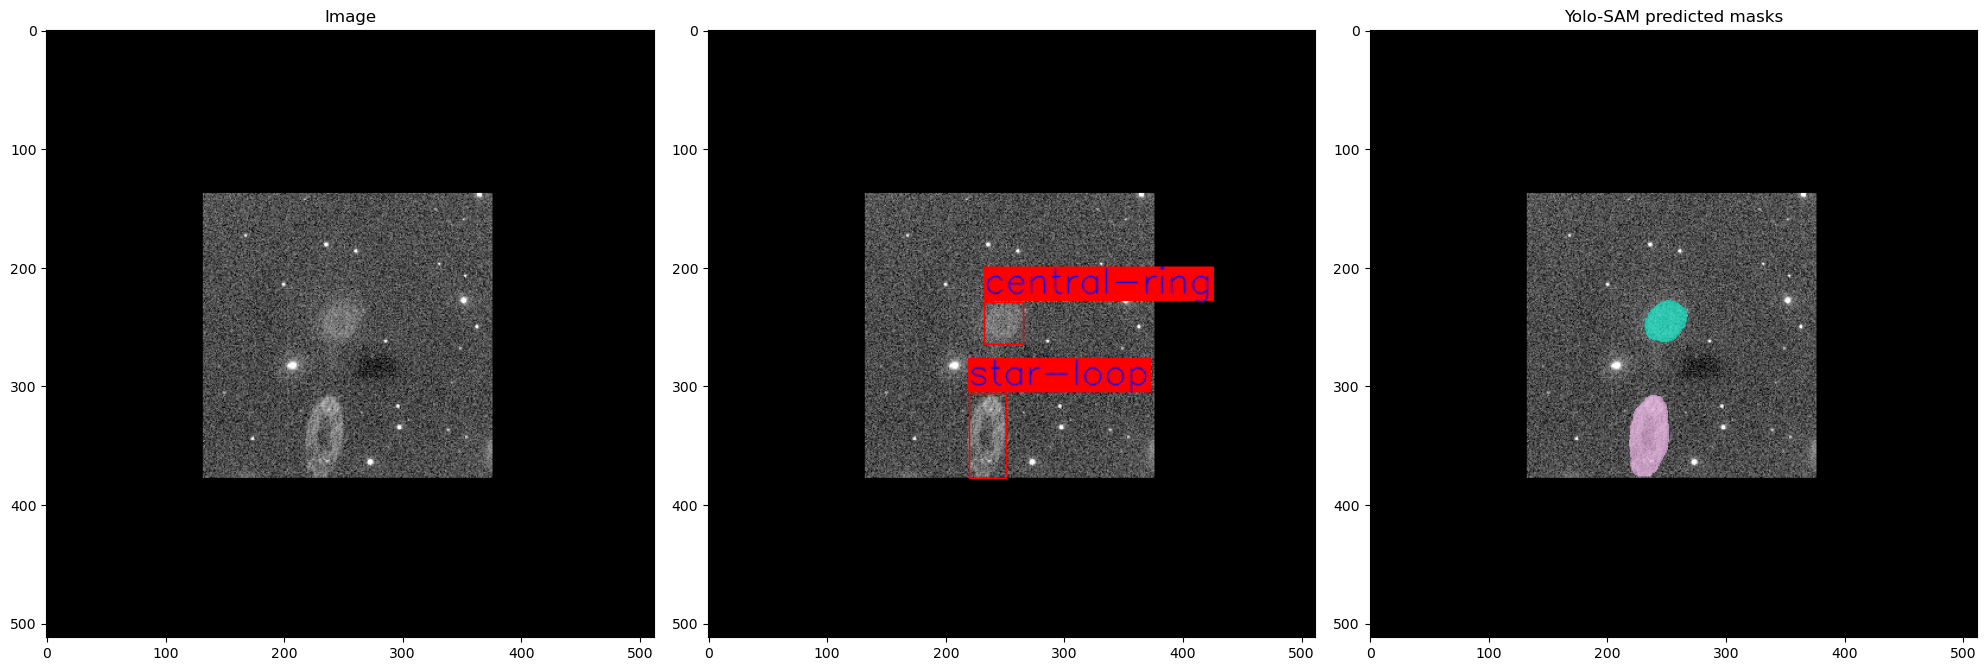

In [6]:
from xami_model.inference.xami_inference import InferXami

detr_checkpoint = f'./xami_model/train/weights/{det_type}_sam_weights/{det_type}_detect_300e_best.pt'
sam_checkpoint = f'./xami_model/train/weights/{det_type}_sam_weights/{det_type}_sam.pth'

detr_sam_pipeline = InferXami(
    device='cpu',
    detr_checkpoint=detr_checkpoint,
    sam_checkpoint=sam_checkpoint,
    model_type='vit_t', # the SAM checkpoint and model_type (vit_h, vit_t, etc.) must be compatible
    use_detr_masks=True,
    detr_type=det_type)

masks = detr_sam_pipeline.run_predict('./example_images/S0893811101_M.png', show_masks=True)

Number of object detected: 17
   read-out-streak
   smoke-ring
   star-loop


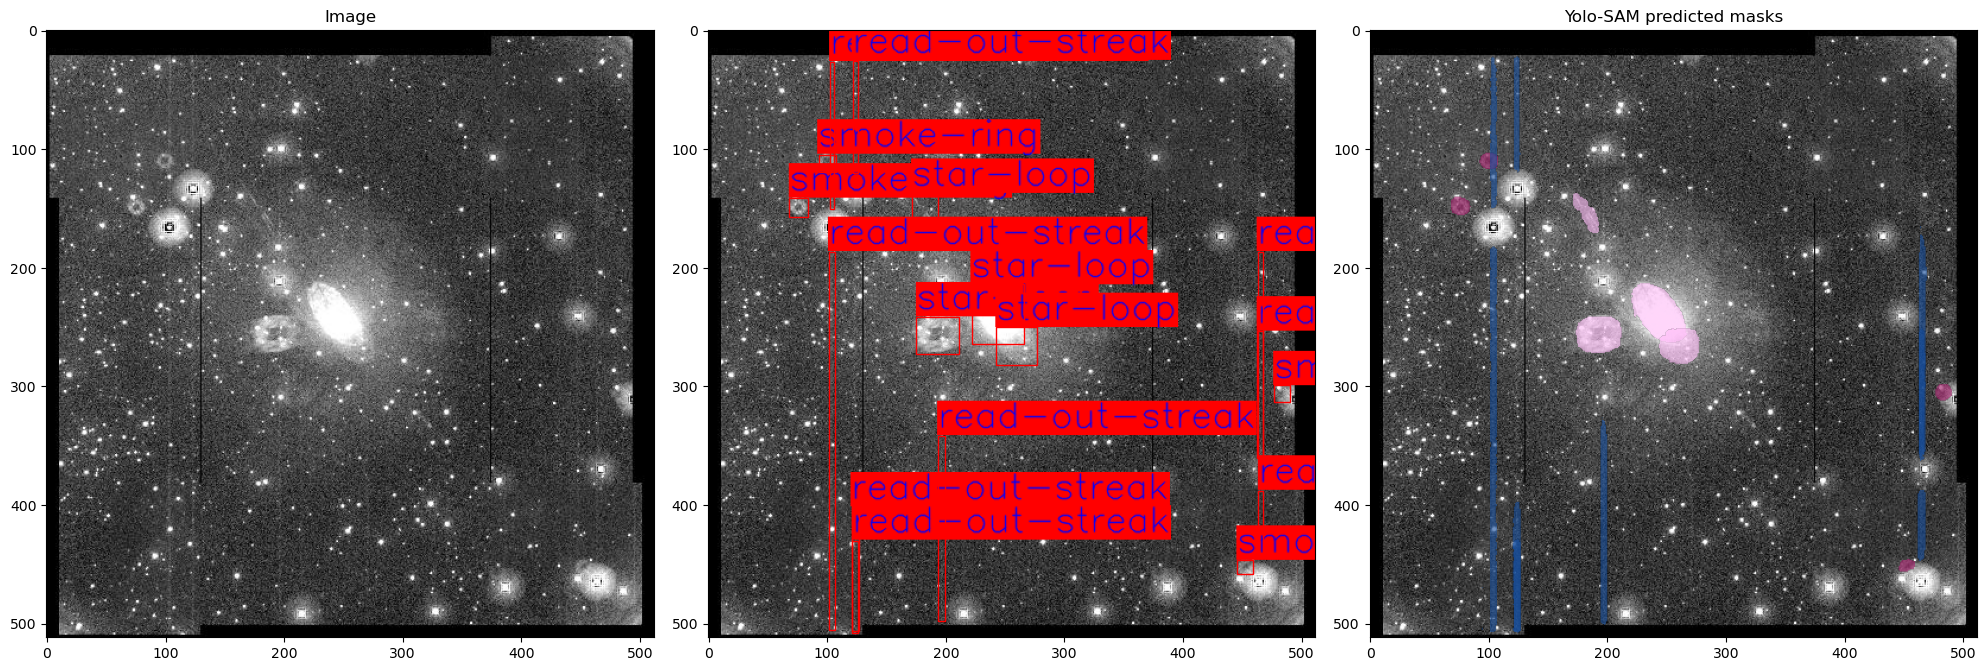

In [7]:
masks = detr_sam_pipeline.run_predict('./example_images/S0743200101_V.jpg', show_masks=True)

Number of object detected: 2
   star-loop


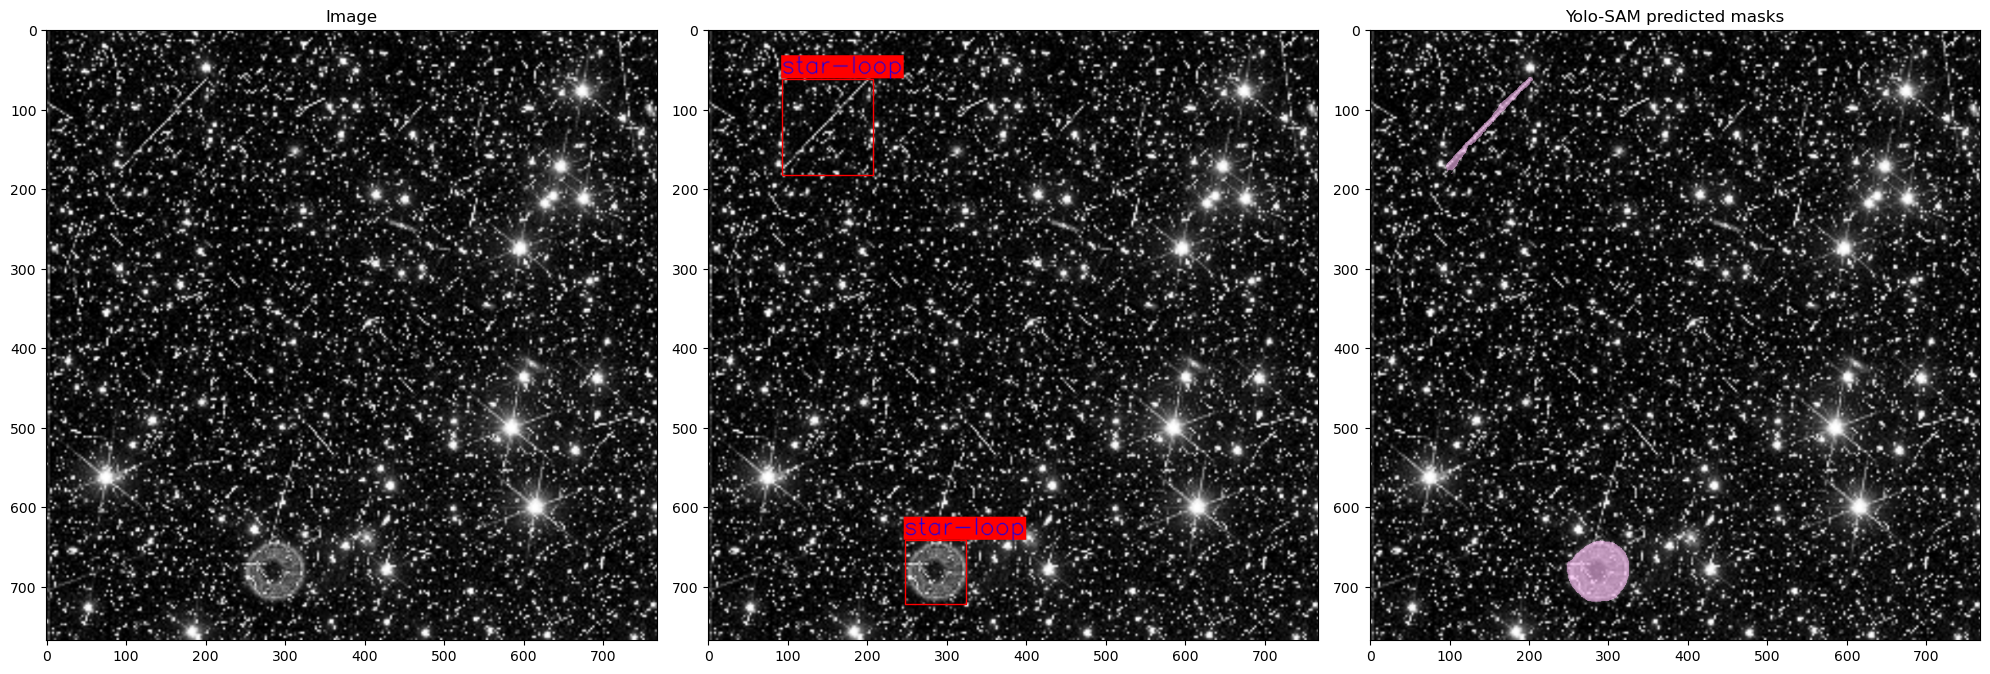

In [8]:
masks = detr_sam_pipeline.run_predict('./example_images/euclid_artefacts.png', show_masks=True, det_conf=0.2)

# Evaluation

Check the [evaluation notebook](./xami_model/train/performance_eval.ipynb) for more details on how to evaluate the model on the XAMI dataset.